# Get Blocks and Transactions

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from store import *

In [2]:
import plyvel
import dbobjects_pb2 as KaspadDB

import kbech32

In [3]:
import hashlib
import struct

def transactionId(t):
    hasher = hashlib.blake2b(digest_size=32, key=b"TransactionID")
    hasher.update(struct.pack(f"<HQ", t.version, len(t.inputs)))
    for ti in t.inputs:
        hasher.update(ti.previousOutpoint.transactionID.transactionId)
        hasher.update(struct.pack(f"<IQQ", ti.previousOutpoint.index, 0, ti.sequence))

    hasher.update(struct.pack(f"<Q", len(t.outputs)))
    for to in t.outputs:
        hasher.update(struct.pack(f"<QHQ", to.value, to.scriptPublicKey.version, len(to.scriptPublicKey.script)))
        hasher.update(to.scriptPublicKey.script)
        
    hasher.update(struct.pack(f"<Q", t.lockTime))
    hasher.update(t.subnetworkID.subnetworkId)
    hasher.update(struct.pack(f"<QQ", t.gas, len(t.payload)))
    hasher.update(t.payload)
    return hasher.digest()

In [28]:
db = plyvel.DB("/media/tmrlvi/Transcend/kaspad-data/kaspa-mainnet/datadir2/")
prefix = db.get(b"active-prefix")

In [72]:
db.close()

In [29]:
blocks = db.prefixed_db(prefix + b"/blocks/")
accepted = db.prefixed_db(prefix + b"/acceptance-data/")

In [30]:
blocksMetadata = {}
for hash_, block_ in blocks.iterator():
    b = KaspadDB.DbBlock()
    b.ParseFromString(block_)
    blocksMetadata[hash_] = {"timestamp": b.header.timeInMilliseconds}

### Get KASPA values from accepted transactions

In [44]:
valuePassed = {}
mined = {}
minedStart = {}
minedEnd = {}

for hash_, block_ in accepted.iterator():
    acpt = KaspadDB.DbAcceptanceData()
    acpt.ParseFromString(block_)
    for b in acpt.blockAcceptanceData:
        for tacpt in b.transactionAcceptanceData:
            if tacpt.isAccepted:
                t = tacpt.transaction
                tid = transactionId(t)
                for i, to in enumerate(t.outputs):
                    address = kbech32.toAddress(to.scriptPublicKey.script)
                    valuePassed[address] = valuePassed.get(address,0) + to.value
                    if len(t.inputs) == 0:
                        mined[address] = mined.get(address,0) + to.value
                        minedStart[address] = min(minedStart.get(address, float("inf")), blocksMetadata[b.blockHash.hash]["timestamp"])
                        minedEnd[address] = max(minedEnd.get(address, float("-inf")), blocksMetadata[b.blockHash.hash]["timestamp"])

### Map outputs to addresses

In [45]:
outputToAddress = {}

for hash_, block_ in blocks.iterator():
    b = KaspadDB.DbBlock()
    b.ParseFromString(block_)
    for t in b.transactions:
        tid = transactionId(t)
        for i, to in enumerate(t.outputs):
            address = kbech32.toAddress(to.scriptPublicKey.script)
            outputToAddress[(tid, i)] = address

### Match inputs to addresses

In [46]:
groups = {}

for hash_, block_ in blocks.iterator():
    b = KaspadDB.DbBlock()
    b.ParseFromString(block_)
    for t in b.transactions:
        # Get all addresses
        addresses = list(set(
            outputToAddress[(ti.previousOutpoint.transactionID.transactionId, ti.previousOutpoint.index)]
            for ti in t.inputs if (ti.previousOutpoint.transactionID.transactionId, ti.previousOutpoint.index) in outputToAddress
        ))
        # Calculate the united group
        group = set()
        for addr in addresses:
            group |= groups.get(addr, set([addr]))
        # Save group info
        for addr in group:
            groups[addr] = group

### Save all in a dataframe

In [47]:
df = pd.DataFrame([ {
    "address": addr, "group": i, "value": valuePassed.get(addr, np.nan)/100000000., "mined": mined.get(addr, np.nan)/100000000.,
    "mineStarted": minedStart.get(addr, None),"mineEnded": minedEnd.get(addr, None)
} for i,g in enumerate(set(map(frozenset, groups.values()))) for addr in g])

In [66]:
df["mineStarted"] = pd.to_datetime(df["mineStarted"], unit="ms")
df["mineEnded"] = pd.to_datetime(df["mineEnded"], unit="ms")

<AxesSubplot:>

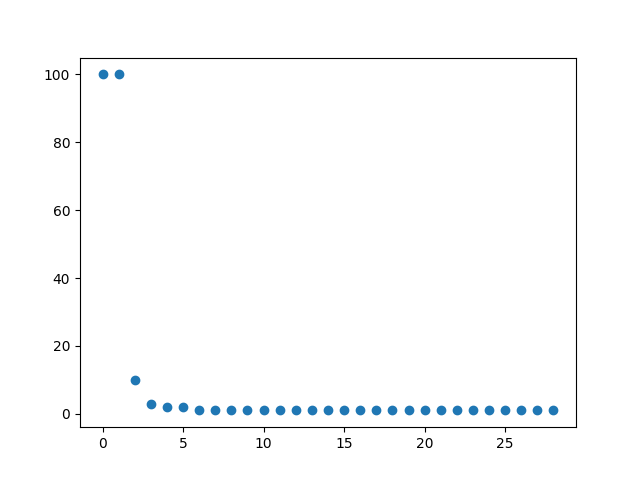

In [67]:
%matplotlib widget
df[df["mined"] > 0].groupby("group")["address"].nunique().sort_values(ascending=False).reset_index(drop=True).plot(marker="o", linestyle="")

In [68]:
df[df["mined"] >0 ].groupby("group")["address"].nunique().sort_values()

group
86        1
3379      1
3221      1
3129      1
2952      1
2862      1
2726      1
2276      1
2262      1
2179      1
1967      1
3660      1
1828      1
1844      1
1421      1
1073      1
1001      1
967       1
683       1
350       1
343       1
1669      1
3717      1
2144      2
1229      2
490       3
3352     10
1547    100
1173    100
Name: address, dtype: int64

In [69]:
df["mined"].sum()

79279520.7221682

In [70]:
df[df["mined"] > 0].groupby("group").agg({"mined": "sum", "address":"nunique"}).sort_values("mined", ascending=False).assign(minedMils = lambda df: df["mined"]/1000000).head(20)

,mined,address,minedMils
group,,,
1547,4.379901e+07,100,43.799011
2262,1.786250e+07,1,17.862505
967,4.611001e+06,1,4.611001
3352,2.646000e+06,10,2.646000
683,1.768501e+06,1,1.768501
1967,1.610501e+06,1,1.610501
1669,1.067500e+06,1,1.067500
1173,8.625001e+05,100,0.862500
3221,7.165002e+05,1,0.716500


In [71]:
df[(df["mined"] > 0) & (df["group"] == 1547)].sort_values("mined", ascending=False)

,address,group,value,mined,mineStarted,mineEnded
5142,kaspa:qzuc29622c9gtk8kc6xeh5mzvxdtpa327484l7dv...,1547,472500.065870,472500.065870,2022-01-31 14:24:49.091000064,2022-02-02 23:28:24.000000000
5584,kaspa:qzkv8s9h374e6gyg2qj5vpatwkxen5ezkj753qk3...,1547,471000.101121,471000.101121,2022-01-31 14:22:27.007000064,2022-02-02 23:26:03.583000064
8903,kaspa:qq86fpsrntmnnkfwxm6phg2su88y8yx4zv66ud38...,1547,465000.072500,465000.072500,2022-01-31 14:21:41.000000000,2022-02-02 23:26:02.000000000
8402,kaspa:qzu5qwm8vaptlnu0d42fh4vaadvw62fgz8a95hzw...,1547,464000.150755,464000.150755,2022-01-31 14:26:37.078000128,2022-02-02 23:27:25.255000064
9460,kaspa:qqa77evqyw4pn9kw64jc7wu2cqv3mwgvmmccs0fp...,1547,463500.084241,463500.084241,2022-01-31 14:21:56.000000000,2022-02-02 23:30:26.030000128
...,...,...,...,...,...,...
12604,kaspa:qqjalsskrwxz66hzgjnqrxsnh8qsjrupljpdw8f9...,1547,413000.093551,413000.093551,2022-01-31 14:32:27.344999936,2022-02-02 23:27:35.592999936
9145,kaspa:qr7kz8d5fxrh036cue75lakvm345lkkeyq8mc6uz...,1547,411500.127221,411500.127221,2022-01-31 14:31:21.556999936,2022-02-02 23:31:01.934000128
10046,kaspa:qqfhwmf70rzy4fntmgdsd588eqtqjc2eukj0sn8w...,1547,411500.087094,411500.087094,2022-01-31 14:25:18.380000000,2022-02-02 23:24:41.000000000
15211,kaspa:qzwxgguakfgp7tnjez97pczl2ymgwwuta6s32f64...,1547,410000.125400,410000.125400,2022-01-31 14:26:37.078000128,2022-02-02 23:30:47.939000064
